# Final Project: MD-GPT

William Bowers

EPS Adv. Prog: TiCS (AIML)

March 6 2024
 

A chatbot specialized in answering biomedical questions.

This tutorial was very helpful with this project and is a fantastic resource for understanding knowledge embedding: 

https://www.youtube.com/watch?v=c_nCjlSB1Zk

## Part 0: Setup

This is Mr. Brigg's OpenAI API key, which we need to call ChatGPT later on. If you are testing this notebook yourself, please use this sparingly so we don't charge him too much money!

Next, import all the libraries we will need throughout. This finishes our setup!

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
from langchain.chat_models import ChatOpenAI
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DataFrameLoader

## Part I: Data Exploration

First, import our dataset and preview it.

In [3]:
# adjust some basic settings in pandas for pretty outputs
plt.rcParams["figure.figsize"] = (6,3)
pd.set_option('display.max_colwidth', None)

# load the dataset and preview the first few rows
df = pd.read_csv('med_dataset.csv')
df.head()

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?,"LCMV infections can occur after exposure to fresh urine, droppings, saliva, or nesting materials from infected rodents. Transmission may also occur when these materials are directly introduced into broken skin, the nose, the eyes, or the mouth, or presumably, via the bite of an infected rodent. Person-to-person transmission has not been reported, with the exception of vertical transmission from infected mother to fetus, and rarely, through organ transplantation."
1,symptoms,What are the symptoms of Lymphocytic Choriomeningitis (LCM) ?,"LCMV is most commonly recognized as causing neurological disease, as its name implies, though infection without symptoms or mild febrile illnesses are more common clinical manifestations. \n \nFor infected persons who do become ill, onset of symptoms usually occurs 8-13 days after exposure to the virus as part of a biphasic febrile illness. This initial phase, which may last as long as a week, typically begins with any or all of the following symptoms: fever, malaise, lack of appetite, muscle aches, headache, nausea, and vomiting. Other symptoms appearing less frequently include sore throat, cough, joint pain, chest pain, testicular pain, and parotid (salivary gland) pain. \n \nFollowing a few days of recovery, a second phase of illness may occur. Symptoms may consist of meningitis (fever, headache, stiff neck, etc.), encephalitis (drowsiness, confusion, sensory disturbances, and/or motor abnormalities, such as paralysis), or meningoencephalitis (inflammation of both the brain and meninges). LCMV has also been known to cause acute hydrocephalus (increased fluid on the brain), which often requires surgical shunting to relieve increased intracranial pressure. In rare instances, infection results in myelitis (inflammation of the spinal cord) and presents with symptoms such as muscle weakness, paralysis, or changes in body sensation. An association between LCMV infection and myocarditis (inflammation of the heart muscles) has been suggested. \n \nPrevious observations show that most patients who develop aseptic meningitis or encephalitis due to LCMV survive. No chronic infection has been described in humans, and after the acute phase of illness, the virus is cleared from the body. However, as in all infections of the central nervous system, particularly encephalitis, temporary or permanent neurological damage is possible. Nerve deafness and arthritis have been reported. \n \nWomen who become infected with LCMV during pregnancy may pass the infection on to the fetus. Infections occurring during the first trimester may result in fetal death and pregnancy termination, while in the second and third trimesters, birth defects can develop. Infants infected In utero can have many serious and permanent birth defects, including vision problems, mental retardation, and hydrocephaly (water on the brain). Pregnant women may recall a flu-like illness during pregnancy, or may not recall any illness. \n \nLCM is usually not fatal. In general, mortality is less than 1%."
2,susceptibility,Who is at risk for Lymphocytic Choriomeningitis (LCM)? ?,"Individuals of all ages who come into contact with urine, feces, saliva, or blood of wild mice are potentially at risk for infection. Owners of pet mice or hamsters may be at risk for infection if these animals originate from colonies that were contaminated with LCMV, or if their animals are infected from other wild mice. Human fetuses are at risk of acquiring infection vertically from an infected mother. \n \nLaboratory workers who work with the virus or handle infected animals are also at risk. However, this risk can be minimized by utilizing animals from sources that regularly test for the virus, wearing proper protective laboratory gear, and following appropriate safety precautions."
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (LCM) ?,"During the first phas

From manual inspection, this dataset has a few duplicate rows (same question AND same response). Weird! Let's delete those.

In [4]:
print(len(df)) # print the length before
df = df.drop_duplicates()
print(len(df)) # print the length after

16407
16359


 After this, it appears that the dataset **doesn't need any further cleaning**. There are some occassional instances of weird stuff going on (since this text is internet scraped), but it's nothing that would blur the meaning, especially since ChatGPT is going to interpret the context I give it. So, let's move on to analyzing the data! I'll start with the qType column so we can examine what types of content the dataset covers (and what it DOESNT cover).

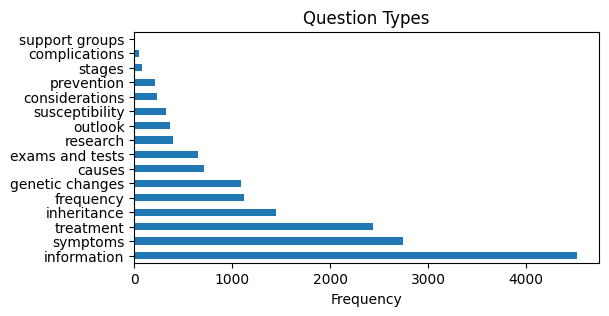

In [5]:
# count the occurences of each value of qtype by using the value_counts function
types = df["qtype"].value_counts()

# now setup a barplot of these counts
types.plot.barh()
plt.xlabel("Frequency")
plt.ylabel("")
plt.title("Question Types")
plt.show()

Let's preview some of the text by printing three random rows to the console

In [6]:
print("\n -----------------------------------------------------------")
sampled = df.sample(n=3)
for question, answer in zip(sampled["Question"], sampled["Answer"]):
    print("Question: " + str(question) + "\n \n")
    print("Answer: " + str(answer))
    print("-----------------------------------------------------------")


 -----------------------------------------------------------
Question: What are the symptoms of Non-Small Cell Lung Cancer ?
 

Answer: Signs of non-small cell lung cancer include a cough that doesn't go away and shortness of breath. Sometimes lung cancer does not cause any signs or symptoms. It may be found during a chest x-ray done for another condition. Signs and symptoms may be caused by lung cancer or by other conditions. Check with your doctor if you have any of the following:         - Chest discomfort or pain.    - A cough that doesnt go away or gets worse over time.     - Trouble breathing.     - Wheezing.     -  Blood in sputum (mucus coughed up from the lungs).     - Hoarseness.     - Loss of appetite.    - Weight loss for no known reason.     - Feeling very tired.    - Trouble swallowing.    - Swelling in the face and/or veins in the neck.
-----------------------------------------------------------
Question: What is (are) mandibuloacral dysplasia ?
 

Answer: Mandibuloacra

Wow, some of these answers are quite long! Let's examine how long our questions and answers are overall.

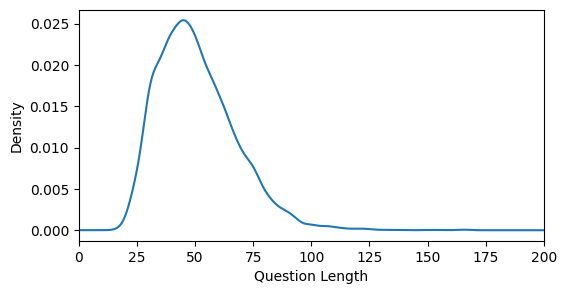

In [7]:
# create a new column with the length of each question
df['qLength'] = df['Question'].apply(lambda x: len(str(x)))

# set up a density plot for that column (like a histogram)
df['qLength'].plot.density()
plt.xlabel('Question Length')
plt.xlim(0, 200)
plt.show()

Now let's do the same thing for the answers.

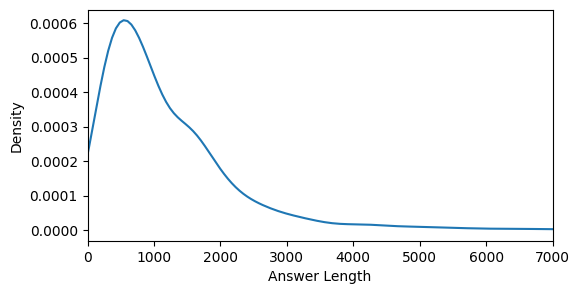

In [8]:
# create a new column with the length of each answer
df['aLength'] = df['Answer'].apply(lambda x: len(str(x)))

# set up a density plot for that column (like a histogram)
df['aLength'].plot.density()
plt.xlabel('Answer Length')
plt.xlim(0, 7000)
plt.show()

Let's end with a word cloud to see what words come up most frequently in the answers. This might allow us to learn more about what exaclty this dataset covers, the level of technicality, etc.

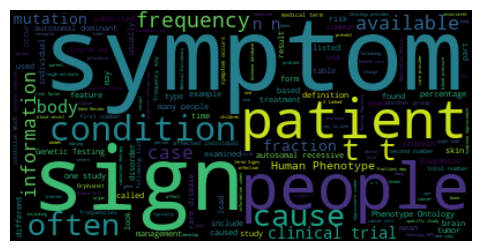

In [9]:
wordcloud_figure = WordCloud().generate(df['Answer'].to_string())
plt.imshow(wordcloud_figure, interpolation='bilinear')
plt.axis("off")
plt.show()

## Part II: Building Model

We need to store our text data in a vector database when building the model. But this can take LONG TIME (5-6 minutes +) with the full dataset. Let's start by sampling from the dataset to increase this runtime.

In [39]:
# NOTE/MODEL TUNING: you can tune how much this samples according to the 
# capability of your machine. with slower machines, it's better to sample less.
# personally, I found 0.7 to offer a good balance between speed and having lots 
# of knowledge/context to feed to the llm.
sampled_df = df.sample(frac=0.7, random_state=10)

# i used to experience issues over the similarity search ONLY picking questions,
# which obviously isn't helpful. therefore, let's create a column with all of 
# the content (the question and the answer COMBINED) which we will use as data
# for the model.
sampled_df["full_content"] = sampled_df["Question"] + sampled_df["Answer"] 
sampled_df_processed = pd.DataFrame(sampled_df["full_content"])

# now load into a format which langchain likes
loader = DataFrameLoader(sampled_df_processed, 
                         page_content_column="full_content")
docs = loader.load()

Professionals in the LLM industry recommend splitting text when dealing with larger textual datasets. Let's use the recommended text splitter from langchain to do that.

In [40]:
# MODEL TUNING: I first had a chunk_size of 500, but this caused the vector 
# database to build too slowly. I then changed it to 3000, which ran faster, but 
# this would grab massive chunks of text with some unnecessary stuff added. 
# I found 2200 to have a nice balance between accuracy and speed. i tried 
# adjusting the chunk_overlap but didn't observe any major differences.
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2200,
    chunk_overlap=100
)
docs_splitted = text_splitter.split_documents(docs)

Lastly, let's encode our text as vectors and store in a vector database with Chroma. This step can be a bit timely, so tune your sampling value according to your hardware capabilities. 

In [41]:
# MODEL TUNING: I originally used the OpenAI embedding function here, but it
# was somewhat expensive (money wise). I tried out a popular free model from 
# hugging face,  and could not notice any difference in performance. therefore, 
# am using free hugging face model for this project. 
embedding_func = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# creating the vector store by embedding our text and storing with chroma. 
# store this in a directory called "./my_vector_db" for easy access when running
# the web app (app.py)
file_name = "./my_vector_db"
os.makedirs(file_name)
vector_db = Chroma.from_documents(docs_splitted, 
                                  embedding_func, 
                                  persist_directory=file_name)

Now our vector database is prepared! Our next step is to load in the model - in this case, ChatGPT -- and to create the prompt that we will send the llm. In the next step, we will combine this with our vector database to create the final model.

In [42]:
# setup the LLM using ChatGPT. using Mr. Briggs' open api key for this.
base_model = ChatOpenAI(openai_api_key=OPENAI_API_KEY)

# prompt that we feed the LLM, including the context. this is the center
# of knowledge embedding
# MODEL TUNING: this required a lot of adjustments to get the desired 
# performance. originally it made super long responses, so i told it to limit
# itself to 300 words. it then had short responses, but didn't incorporate 
# much information from the context. therefore, I told it to incorporate as much
# of the context is rexievced as possible. lastly, the model would occassionally
# mention that it had receieved context, saying something like "based on the 
# context I receieved...". I therefore told it to not mention this when 
# giving the user a response.
prompt_skeleton = """
Imagine you are a doctor helping patients understanding medical conditions.
You are being sent a question from a client and need to respond. Together with
their question, you will also recieve some context on that topic. DO NOT mention 
that you have recieved this context. When responding, incorporate as much of the 
context as possible. Make sure your response is specific and detailed but
not longer than 300 words. If the query doesn't match the context provided, 
do the best with whatever knowledge you have. 

Here is your client's question: {query}

Here is the context that I have fetched for you: {context}
"""

Now we have all the pieces in place. Lets create a function that takes the user's biomedical question and gives the response from the model.

In [43]:
# function that takes the query and gives the response
def get_model_response(user_query, print_context=False):

    # first, run the similarity search on the vector store. get 3 relevant 
    # text snippets to feed into the llm as context
    # MODEL TUNING: I originally had the model fetch 1 piece of context, but 
    # this often missed out on some key information (and the responses weren't
    # always super detailed/specific). I then changed it to fetch 5 snippets,
    # but often times a couple of them were unhelpful and unnecessary. I found
    # that fetching 3 snippets was a good balance between getting lots of 
    # information and being efficient (i.e., not sending too much text to 
    # OpenAI, since this is what determines how much you pay).
    relevant_info = vector_db.similarity_search(user_query, k=3)

    # fetch the actual results from the search (drop the metadata and other
    # unnecessary stuff)
    context = [item.page_content for item in relevant_info]

    # maybe print out the context (for debugging purposes)
    if print_context:
        print("--------------------------------------------------")
        for item in context:
            print(item + "\n")
            print("--------------------------------------------------")

    # add the query and context into our prompt skeleton
    full_prompt = prompt_skeleton.format(query=user_query, context=context)

    # now input this, along with the user query, into our LLM
    response = base_model.invoke(full_prompt)

    # extract just the string (drop unnecessary stuff) and return
    ret_val = response.content
    return str(ret_val)

Let's see if we can actually fetch context by printing it out.

In [44]:
get_model_response("tell me about diabetes", print_context=True)

--------------------------------------------------
What is (are) Diabetes ?Diabetes means your blood glucose (often called blood sugar) is too high. Your blood always has some glucose in it because your body needs glucose for energy to keep you going. But too much glucose in the blood isn't good for your health. Glucose comes from the food you eat and is also made in your liver and muscles. Your blood carries the glucose to all of the cells in your body. Insulin is a chemical (a hormone) made by the pancreas. The pancreas releases insulin into the blood. Insulin helps the glucose from food get into your cells. If your body does not make enough insulin or if the insulin doesn't work the way it should, glucose can't get into your cells. It stays in your blood instead. Your blood glucose level then gets too high, causing pre-diabetes or diabetes.

--------------------------------------------------
production, quality, or action in the body.  - Other types of diabetes are caused by disease

"Diabetes is a condition where your blood glucose, also known as blood sugar, is too high. Glucose is a form of sugar that comes from the food you eat and is also produced in your liver and muscles. Normally, insulin, a hormone made by the pancreas, helps the glucose from food enter your cells to be used for energy. In diabetes, either the body doesn't produce enough insulin or the insulin doesn't work effectively, leading to high levels of glucose in the blood.\n\nThere are three main types of diabetes: type 1, type 2, and gestational diabetes. Type 1 diabetes typically develops in young individuals when the immune system attacks and destroys the insulin-producing cells in the pancreas. People with type 1 diabetes need to take insulin to manage their condition. On the other hand, type 2 diabetes is more common and often develops in middle-aged or older individuals. In type 2 diabetes, the body becomes resistant to insulin or doesn't produce enough of it.\n\nIf left unmanaged, high blo

In [45]:
get_model_response("tell me about heart disease", print_context=True)

--------------------------------------------------
What is (are) Heart Diseases ?If you're like most people, you think that heart disease is a problem for others. But heart disease is the number one killer in the U.S. It is also a major cause of disability. There are many different forms of heart disease. The most common cause of heart disease is narrowing or blockage of the coronary arteries, the blood vessels that supply blood to the heart itself. This is called coronary artery disease and happens slowly over time. It's the major reason people have heart attacks.     Other kinds of heart problems may happen to the valves in the heart, or the heart may not pump well and cause heart failure. Some people are born with heart disease.    You can help reduce your risk of heart disease by taking steps to control factors that put you at greater risk:       -  Control your blood pressure    -  Lower your cholesterol    -  Don't smoke    -  Get enough exercise       NIH: National Heart, Lung, 

"Heart disease is a serious and prevalent condition that affects many individuals. It is the number one killer in the U.S. and a major cause of disability. There are various forms of heart disease, with the most common being coronary artery disease, which involves the narrowing or blockage of the coronary arteries that supply blood to the heart. This can lead to heart attacks over time.\n\nAdditionally, heart valve disease can occur when one or more of the heart valves do not function properly. The heart has four valves - tricuspid, pulmonary, mitral, and aortic - which open and close with each heartbeat to ensure proper blood flow through the heart's chambers.\n\nIn women, heart disease is a significant concern, with 1 in 4 women in the U.S. dying from heart disease. Coronary artery disease is a common issue in both men and women, but women may also be at risk for coronary microvascular disease (MVD) and broken heart syndrome. It is important for women of all ages to be mindful of hea

Looks pretty good! Let's move on to testing the overall behavior of the model as a whole.

## Part III: Testing Model

Let's see how the model is doing by comparing it to an example question and answer, as well as the output by ChatGPT (without context.)

In [49]:
df[df["Question"] == "What are the symptoms of Lymphocytic Choriomeningitis (LCM) ?"]

,qtype,Question,Answer,qLength,aLength
1,symptoms,What are the symptoms of Lymphocytic Choriomeningitis (LCM) ?,"LCMV is most commonly recognized as causing neurological disease, as its name implies, though infection without symptoms or mild febrile illnesses are more common clinical manifestations. \n \nFor infected persons who do become ill, onset of symptoms usually occurs 8-13 days after exposure to the virus as part of a biphasic febrile illness. This initial phase, which may last as long as a week, typically begins with any or all of the following symptoms: fever, malaise, lack of appetite, muscle aches, headache, nausea, and vomiting. Other symptoms appearing less frequently include sore throat, cough, joint pain, chest pain, testicular pain, and parotid (salivary gland) pain. \n \nFollowing a few days of recovery, a second phase of illness may occur. Symptoms may consist of meningitis (fever, headache, stiff neck, etc.), encephalitis (drowsiness, confusion, sensory disturbances, and/or motor abnormalities, such as paralysis), or meningoencephalitis (inflammation of both the brain and meninges). LCMV has also been known to cause acute hydrocephalus (increased fluid on the brain), which often requires surgical shunting to relieve increased intracranial pressure. In rare instances, infection results in myelitis (inflammation of the spinal cord) and presents with symptoms such as muscle weakness, paralysis, or changes in body sensation. An association between LCMV infection and myocarditis (inflammation of the heart muscles) has been suggested. \n \nPrevious observations show that most patients who develop aseptic meningitis or encephalitis due to LCMV survive. No chronic infection has been described in humans, and after the acute phase of illness, the virus is cleared from the body. However, as in all infections of the central nervous system, particularly encephalitis, temporary or permanent neurological damage is possible. Nerve deafness and arthritis have been reported. \n \nWomen who become infected with LCMV during pregnancy may pass the infection on to the fetus. Infections occurring during the first trimester may result in fetal death and pregnancy termination, while in the second and third trimesters, birth defects can develop. Infants infected In utero can have many serious and permanent birth defects, including vision problems, mental retardation, and hydrocephaly (water on the brain). Pregnant women may recall a flu-like illness during pregnancy, or may not recall any illness. \n \nLCM is usually not fatal. In general, mortality is less than 1%.",61,2558


In [51]:
print("MD-GPT: " + get_model_response("tell me about Lymphocytic Choriomeningitis."))
print("\n--------------------------------------------------------------------")
print("ChatGPT: " + base_model.invoke("tell me about Lymphocytic Choriomeningitis.").content)

MD-GPT: Lymphocytic Choriomeningitis (LCM) is a viral infection that can lead to various neurological complications. The symptoms of LCMV infection usually present themselves 8-13 days after exposure to the virus. Initially, patients may experience fever, malaise, muscle aches, headache, nausea, and vomiting. Less common symptoms include sore throat, cough, joint pain, chest pain, testicular pain, and parotid (salivary gland) pain. 

Following a period of recovery, a second phase of illness may occur, which can manifest as meningitis, encephalitis, or meningoencephalitis. LCMV infection can also lead to acute hydrocephalus, myelitis, and even myocarditis in rare cases. It's important to note that most patients who develop aseptic meningitis or encephalitis due to LCMV tend to survive, but temporary or permanent neurological damage is possible.

Treatment for Lymphocytic Choriomeningitis typically involves hospitalization and supportive care, depending on the severity of the condition. 

That looks pretty good! MD-GPT certainly has extra knowledge compared to ChatGPT. But note that the model doesn't have the same output on every run, so sometimes it's better than otheres. Let's do another research-focused question.

In [57]:
df[df["Question"] == "What is (are) hypokalemic periodic paralysis ?"]

,qtype,Question,Answer,qLength,aLength
10618,information,What is (are) hypokalemic periodic paralysis ?,"Hypokalemic periodic paralysis is a condition that causes episodes of extreme muscle weakness typically beginning in childhood or adolescence. Most often, these episodes involve a temporary inability to move muscles in the arms and legs. Attacks cause severe weakness or paralysis that usually lasts from hours to days. Some people may have episodes almost every day, while others experience them weekly, monthly, or only rarely. Attacks can occur without warning or can be triggered by factors such as rest after exercise, a viral illness, or certain medications. Often, a large, carbohydrate-rich meal or vigorous exercise in the evening can trigger an attack upon waking the following morning. Although affected individuals usually regain their muscle strength between attacks, repeated episodes can lead to persistent muscle weakness later in life. People with hypokalemic periodic paralysis have reduced levels of potassium in their blood (hypokalemia) during episodes of muscle weakness. Researchers are investigating how low potassium levels may be related to the muscle abnormalities in this condition.",46,1111


In [58]:
print("MD-GPT: " + get_model_response("tell me about Hypokalemic periodic paralysis"))
print("\n--------------------------------------------------------------------")
print("ChatGPT: " + base_model.invoke("tell me about Hypokalemic periodic paralysis").content)

MD-GPT: Hypokalemic periodic paralysis is a condition characterized by episodes of extreme muscle weakness, usually starting in childhood or adolescence. During these episodes, individuals may experience temporary paralysis in their arms and legs, which can last from hours to days. These attacks can occur without warning or be triggered by factors like rest after exercise, certain medications, or even a large, carbohydrate-rich meal.

Individuals with hypokalemic periodic paralysis often have reduced levels of potassium in their blood during episodes of muscle weakness. While muscle strength typically returns between attacks, repeated episodes can lead to persistent muscle weakness later in life. The weakness or paralysis is commonly found in the shoulders and hips, affecting the muscles of the arms and legs. It may also affect muscles involved in eye movement, breathing, and swallowing.

The frequency of attacks varies among individuals, with some experiencing them daily and others on

Looks quite good! ChatGPT is obviously good too, but MD-GPT is nicely incorporating the context from the dataset. It seems to emulate the style of the dataset decently.

You can also test the model out in a more visual way using the app.py file.